# Laboratorio 6 - Candidatos

#### 20880 Sebastian Aristondo
#### 20293 Daniel Gonzalez

## 2. Carga de datos

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from nltk.corpus import opinion_lexicon
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
import datetime
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
from langdetect import detect
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [93]:
data_bernardo = pd.read_csv("bernardoArevalo.csv", sep = ",", encoding = "utf-8")
data_bernardo = data_bernardo.drop('Unnamed: 0', axis = 1)

data_sandra = pd.read_csv("sandraTorres.csv", sep = ",", encoding = "utf-8")
data_sandra = data_sandra.drop('Unnamed: 0', axis = 1)

## 3. Limpieza y preprocesamiento de datos

El dataset tiene los datos crudos, por lo que debemos de limpiarlos y preprocesarlos para poder trabajar con ellos. Para esto, se utilizo la libreria pandas para poder leer el archivo csv y poder trabajar con el. Luego utilizaremos varias funciones de nltk para poder limpiar los datos y dejarlos listos para poder trabajar con ellos.

In [94]:
def remove_urls(rawContent):
    url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    return re.sub(url_pattern, '', rawContent)

Se realizaron tres acciones iniciales para limpiar y preprocesar datos. Primero se eliminó cualquier URL de los datos usando una expresión regular. También se mantuvieron solamente los caracteres que estuvieran de la a a la z, mayúsculas o minúsculas. Esto quiere decir que se quitó cualquier caracter como "#" o "@" y signos de puntuación. Por otra parte, se pasaron todas las palabras a minúsculas.

In [95]:
def remove_tildes(rawContent):
    rawContent = rawContent.replace('á', 'a')
    rawContent = rawContent.replace('é', 'e')
    rawContent = rawContent.replace('í', 'i')
    rawContent = rawContent.replace('ó', 'o')
    rawContent = rawContent.replace('ú', 'u')
    return rawContent

In [96]:
data_bernardo['rawContent'] = data_bernardo['rawContent'].apply(remove_urls)
data_bernardo['rawContent'] = data_bernardo['rawContent'].apply(lambda x: x.lower())
data_bernardo['rawContent'] = data_bernardo['rawContent'].apply(remove_tildes)

data_sandra['rawContent'] = data_sandra['rawContent'].apply(remove_urls)
data_sandra['rawContent'] = data_sandra['rawContent'].apply(lambda x: x.lower())
data_sandra['rawContent'] = data_sandra['rawContent'].apply(remove_tildes)

In [97]:
data_bernardo['rawContent'] = data_bernardo['rawContent'].str.replace('[^a-zA-Z0-9]', ' ', regex=True)
data_sandra['rawContent'] = data_sandra['rawContent'].str.replace('[^a-zA-Z]', ' ', regex=True)

Se removieron URLS y se quitaron caracteres especiales. También se pasaron todos los tweets a minúsculas y se removieron las tildes, para poder tener una forma estandarizada de los símbolos de los tweets en el dataset.

In [98]:
def remove_stop_words(sentence):
    stop_words = set(stopwords.words('spanish'))  
    words = sentence.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    new_sentence = ' '.join(filtered_words)
    return new_sentence

data_bernardo['rawContent_clean'] = data_bernardo['rawContent'].apply(remove_stop_words)
data_sandra['rawContent_clean'] = data_sandra['rawContent'].apply(remove_stop_words)

Se eliminaron las stop words en español que pudiera tener el dataset.

In [99]:
data_bernardo['rawContent_clean'].head()

0    anongtreloaded msemillagt barevalodeleon jajaj...
1    asiervera aztecanoticiagt barevalodeleon dos v...
2    paciente 39 dolor lumbar 1 tras caida hizo 45 ...
3    viczacariasgt 502 barevalodeleon msemillagt co...
4    igor bitkov sigan juego ruso invasor enero sol...
Name: rawContent_clean, dtype: object

In [100]:
data_sandra['rawContent_clean'].head()

0    bernardosilvagt barevalodeleon drgiammattei me...
1    awskl mjcabrerar barevalodeleon tseguatemala d...
2    the national race walking championship amp you...
3    palomin mjcabrerar barevalodeleon tseguatemala...
4    asolaresm mike barevalodeleon estupido cegado ...
Name: rawContent_clean, dtype: object

In [101]:
def lemmatize_words(words):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return lemmatized_words

data_sandra['rawContent_lemmatized'] = data_sandra['rawContent_clean'].apply(lambda x: lemmatize_words(x.split()))
data_sandra['rawContent_lemmatized_text'] = data_sandra['rawContent_lemmatized'].apply(lambda x: ' '.join(x))

data_bernardo['rawContent_lemmatized'] = data_bernardo['rawContent_clean'].apply(lambda x: lemmatize_words(x.split()))
data_bernardo['rawContent_lemmatized_text'] = data_bernardo['rawContent_lemmatized'].apply(lambda x: ' '.join(x))

Con el objetivo de analizar de una manera más sencilla los tweets los lematizaremos para poder obtener palabras clave como zona y lluvia.


In [102]:
def delete_non_spanish_tweets(texto):
    try:
        return detect(texto) == 'es'
    except:
        # Si no se puede detectar el idioma, se asume que no es español
        return False

In [103]:
data_bernardo = data_bernardo[data_bernardo['rawContent'].apply(delete_non_spanish_tweets)]
data_sandra = data_sandra[data_sandra['rawContent'].apply(delete_non_spanish_tweets)]

In [104]:
def extraer_valor(diccionario):
    diccionario = eval(diccionario)
    return diccionario["username"]

data_bernardo["username"]=data_bernardo["user"].apply(extraer_valor)
data_sandra["username"]=data_sandra["user"].apply(extraer_valor)

In [105]:
# Cargar el modelo pre-entrenado de BERT para análisis de sentimiento
model_name = 'nlptown/bert-base-multilingual-uncased-sentiment'
model = BertForSequenceClassification.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)

# Crear una función para realizar análisis de sentimiento
def analyze_sentiment(text):
    # Tokenizar el texto y obtener la salida del modelo
    inputs = tokenizer(text, return_tensors='pt')
    outputs = model(**inputs)

    # Obtener la predicción de sentimiento
    prediction = torch.argmax(outputs.logits, dim=1).item()
    
    # Definir la escala de sentimiento
    sentiment_scale = {
        0: 'Muy negativo',
        1: 'Negativo',
        2: 'Neutral',
        3: 'Positivo',
        4: 'Muy positivo'
    }
    
    # Obtener la etiqueta de sentimiento
    sentiment_label = sentiment_scale[prediction]
    
    return sentiment_label


In [106]:
def verificar_sentimiento(dataframe, columna,data):

    for valor in dataframe[columna]:
        filas = data[data['username'] == valor]
        result = filas['rawContent_clean'].apply(analyze_sentiment)
        frecuencia_valores = result.value_counts()
        valor_mas_comun = frecuencia_valores.idxmax()
        print("Los tweets del usuario ", valor, " son mayormente ", valor_mas_comun)
    

In [107]:
def generate_wordcloud(text):
    wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [118]:
def verificar_sentimiento_tweet(tweets):
    sentiments = []
    for valor in tweets:
        result = analyze_sentiment(valor)
        sentiments.append(result)
    
    # Obtener la frecuencia de cada sentimiento
    frecuencia_sentimientos = Counter(sentiments)
    
    # Extrae las etiquetas de sentimientos y las frecuencias
    etiquetas = frecuencia_sentimientos.keys()
    frecuencias = frecuencia_sentimientos.values()

    # Crea el gráfico de barras
    plt.bar(etiquetas, frecuencias)

    # Añade etiquetas y título
    plt.xlabel('Sentimientos')
    plt.ylabel('Frecuencia')
    plt.title('Frecuencia de Sentimientos')

    # Muestra el gráfico
    plt.show()

## 4. Análisis exploratorio de datos

In [151]:
def interaction_centralization(i_max, retweet_count_list, n):
    C = 0
    for retweet_count in retweet_count_list:
        C += (i_max - retweet_count)
    C = 1 - (C / ((n - 1) * (n - 2)))
    return C


### 4.1 Análisis exploratorio Bernardo Arévalo

In [108]:
data_bernardo.shape

(3619, 32)

In [109]:
data_bernardo.columns

Index(['id', 'id_str', 'url', 'date', 'user', 'lang', 'rawContent',
       'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
       'conversationId', 'hashtags', 'cashtags', 'mentionedUsers', 'links',
       'viewCount', 'retweetedTweet', 'quotedTweet', 'place', 'coordinates',
       'inReplyToTweetId', 'inReplyToUser', 'source', 'sourceUrl',
       'sourceLabel', 'media', '_type', 'rawContent_clean',
       'rawContent_lemmatized', 'rawContent_lemmatized_text', 'username'],
      dtype='object')

Primero veremos si el dataset cuenta con coordenadas para realizar algunos estudios demográficos

In [110]:
nas_coordenadas = data_bernardo['coordinates'].isna().sum()
print('Porcentaje de tweets sin coordenadas: ', nas_coordenadas/data_bernardo.shape[0]*100)

print("Cantidad de tweets con coordenadas: ", data_bernardo.shape[0] - nas_coordenadas)


Porcentaje de tweets sin coordenadas:  100.0
Cantidad de tweets con coordenadas:  0


El dataset no cuenta con coordenadas por lo que no podremos hacer estudios demográficos

In [69]:
usuarios = data_bernardo['user'].unique()
print('Cantidad de usuarios unicos en el dataset: ', len(usuarios))

Cantidad de usuarios unicos en el dataset:  1409


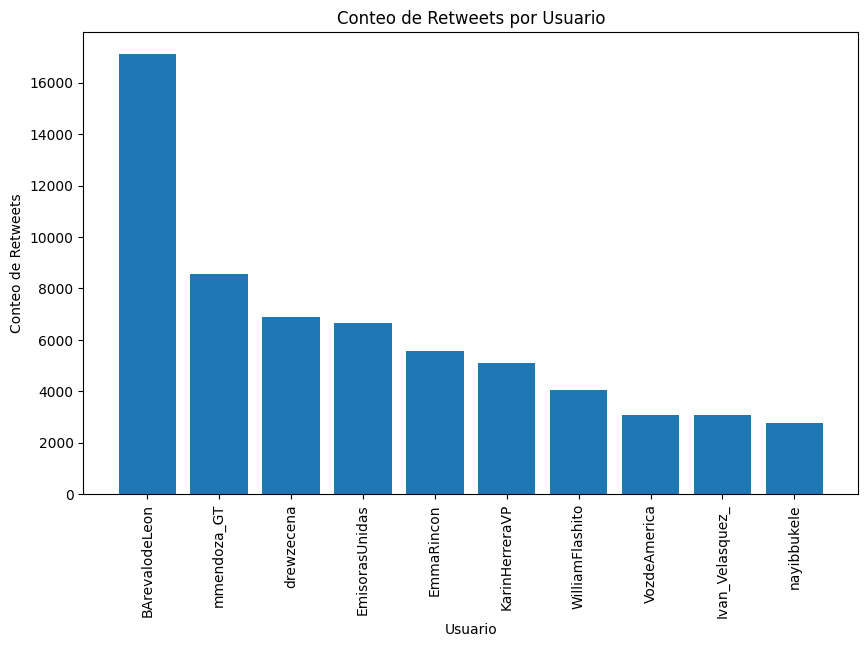

In [70]:
tweets_mas_rt_b = data_bernardo.groupby('username')['retweetCount'].sum()
tr_count_df_b = tweets_mas_rt_b.reset_index()
tr_count_df_b = tr_count_df_b.rename(columns={'retweetCount': 'count'})
tr_count_df_b = tr_count_df_b.sort_values(by='count', ascending=False)
tr_count_df_b = tr_count_df_b.head(10)

plt.figure(figsize=(10, 6))  # Tamaño del gráfico
plt.bar(tr_count_df_b['username'], tr_count_df_b['count'])
plt.xlabel('Usuario')
plt.ylabel('Conteo de Retweets')
plt.title('Conteo de Retweets por Usuario')
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x para una mejor visualización
plt.show()


In [71]:
print(f"Como podemos ver el usuario {tr_count_df_b.iloc[0]['username']} pareciera ser un usuario muy activo en Twitter en cuanto a tweets \nrelacionados al tráfico. Mucha gente comparte la información que el público. Este hallazgo es interesante ya que asumimos \nque el mayor referente sobre este rubro sería prensa libre, Amílcar Montejo o algún otro medio de comunicación.")


Como podemos ver el usuario BArevalodeLeon pareciera ser un usuario muy activo en Twitter en cuanto a tweets 
relacionados al tráfico. Mucha gente comparte la información que el público. Este hallazgo es interesante ya que asumimos 
que el mayor referente sobre este rubro sería prensa libre, Amílcar Montejo o algún otro medio de comunicación.


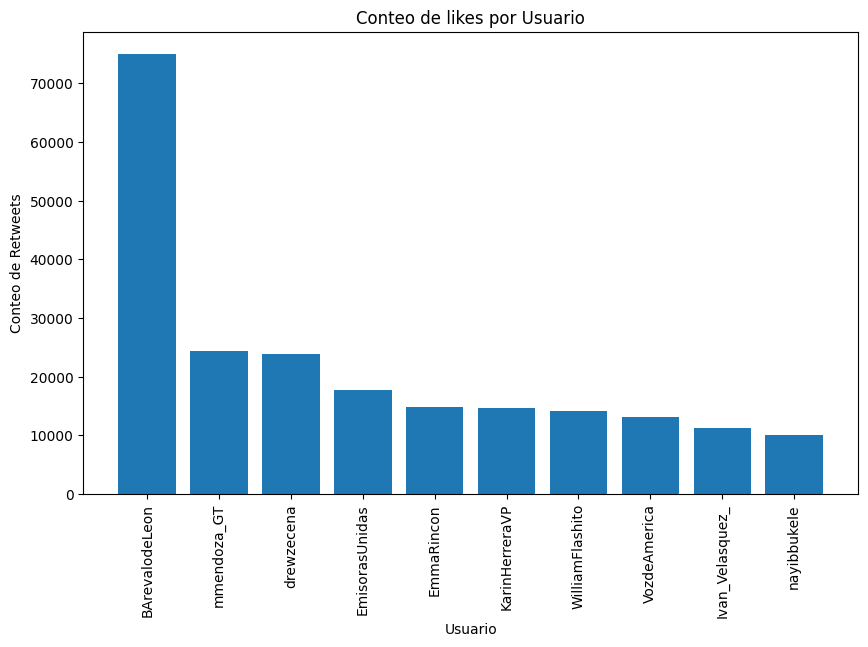

In [75]:
tweets_mas_likes_b = data_bernardo.groupby('username')['likeCount'].sum()
tr_count_df_likes_b = tweets_mas_likes_b.reset_index()
tr_count_df_likes_b = tr_count_df_likes_b.rename(columns={'likeCount': 'count'})
tr_count_df_likes_b = tr_count_df_likes_b.sort_values(by='count', ascending=False)
tr_count_df_likes_b = tr_count_df_likes_b.head(10)

plt.figure(figsize=(10, 6))  # Tamaño del gráfico
plt.bar(tr_count_df_b['username'], tr_count_df_likes_b['count'])
plt.xlabel('Usuario')
plt.ylabel('Conteo de Retweets')
plt.title('Conteo de likes por Usuario')
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x para una mejor visualización
plt.show()

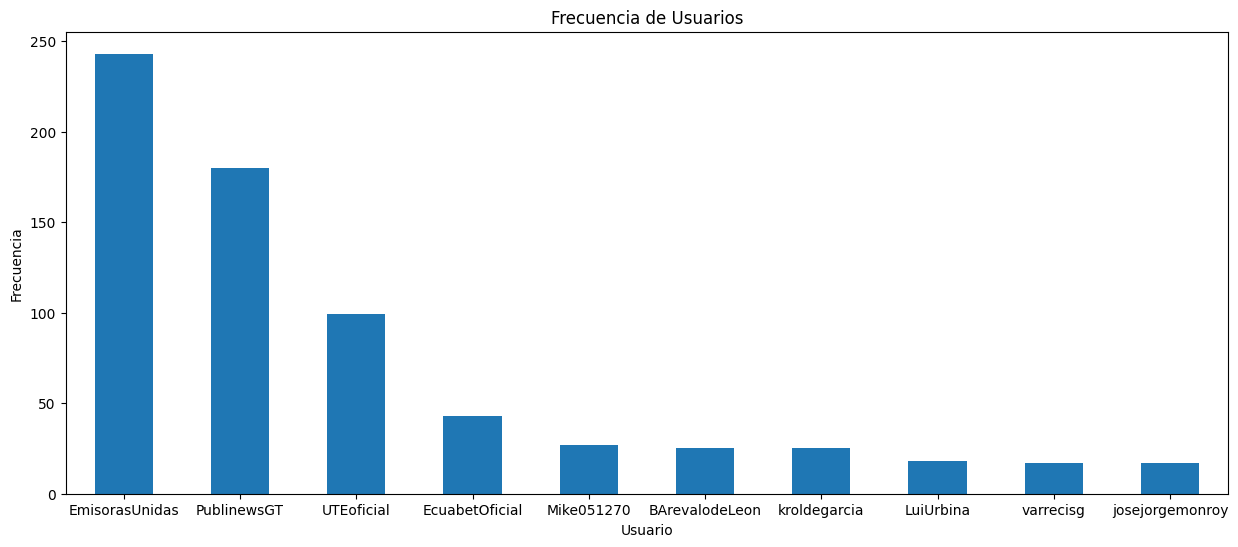

In [73]:
frecuencia_usuarios_b = data_bernardo['username'].value_counts()

usuarios_ordenados_b = frecuencia_usuarios_b.sort_values(ascending=False)

# Tomar los 10 usuarios más frecuentes
top_10_usuarios_b = usuarios_ordenados_b.head(10)

# Crear un gráfico de barras
plt.figure(figsize=(15, 6))  # Tamaño del gráfico
top_10_usuarios_b.plot(kind='bar')
plt.xlabel('Usuario')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Usuarios')
plt.xticks(rotation=0)  # Rotar las etiquetas del eje x para una mejor visualización
plt.show()

In [79]:
#print("Los sentimientos de los tweets de los usuarios que tienen más retweets son:")
verificar_sentimiento(tr_count_df_b, "username",data_bernardo)

Los tweets del usuario  BArevalodeLeon  son mayormente  Muy negativo
Los tweets del usuario  mmendoza_GT  son mayormente  Muy negativo
Los tweets del usuario  drewzecena  son mayormente  Muy negativo
Los tweets del usuario  EmisorasUnidas  son mayormente  Muy negativo
Los tweets del usuario  EmmaRincon  son mayormente  Muy negativo
Los tweets del usuario  KarinHerreraVP  son mayormente  Muy positivo
Los tweets del usuario  WilliamFlashito  son mayormente  Muy negativo
Los tweets del usuario  VozdeAmerica  son mayormente  Muy negativo
Los tweets del usuario  Ivan_Velasquez_  son mayormente  Muy positivo
Los tweets del usuario  nayibbukele  son mayormente  Muy positivo


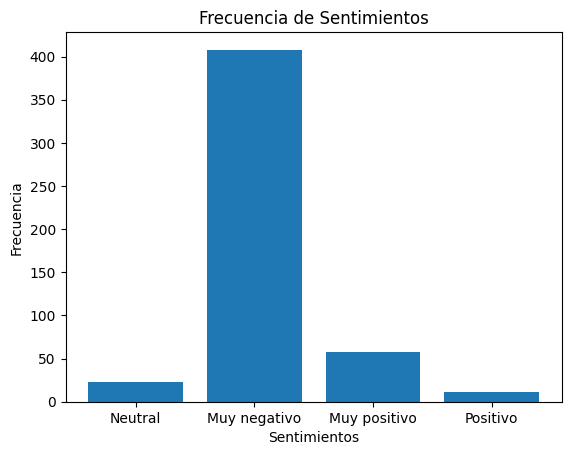

In [157]:
tweets_b = data_bernardo['rawContent_clean'].sample(500)
verificar_sentimiento_tweet(tweets_b)


In [158]:
retweet_count = data_bernardo['retweetCount'].values
max = np.max(retweet_count)
min = np.min(retweet_count)
retweet_count = (retweet_count - min) / (max - min)
max = 1
min = 0
n = len(retweet_count)
C = interaction_centralization(max, retweet_count, n)
print("La métrica de centralización, basada en interacciones para los tweets de Bernardo Arevalo es:", C)

La métrica de centralización, basada en interacciones para los tweets de Bernardo Arevalo es: 0.9997252302239937


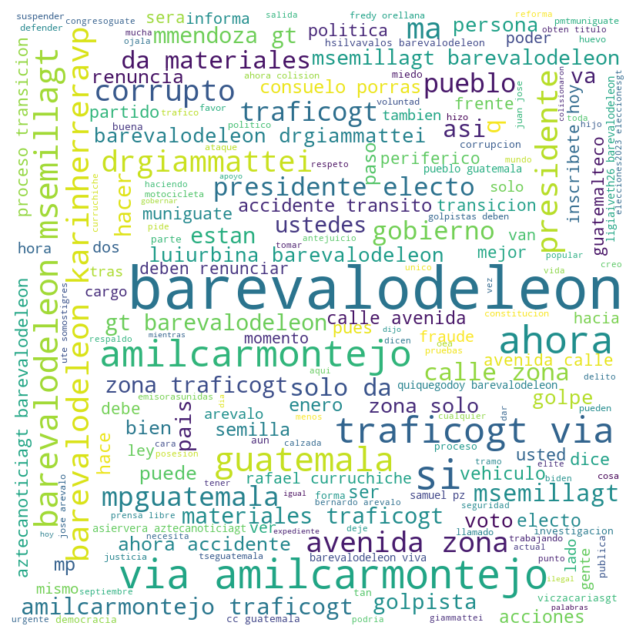

In [159]:
generate_wordcloud(' '.join(tweets_b))

### 4.2 Análisis exploratorio Sandra Torres

In [111]:
data_sandra.shape

(5014, 32)

In [112]:
nas_coordenadas_sandra = data_sandra['coordinates'].isna().sum()
print('Porcentaje de tweets sin coordenadas: ', nas_coordenadas_sandra/data_sandra.shape[0]*100)

print("Cantidad de tweets con coordenadas: ", data_sandra.shape[0] - nas_coordenadas_sandra)


Porcentaje de tweets sin coordenadas:  100.0
Cantidad de tweets con coordenadas:  0


Como se puede observar, ninguno de los tweets tiene coordenadas, por lo tanto, no es posible realizar un análisis demográfico de los tweets.

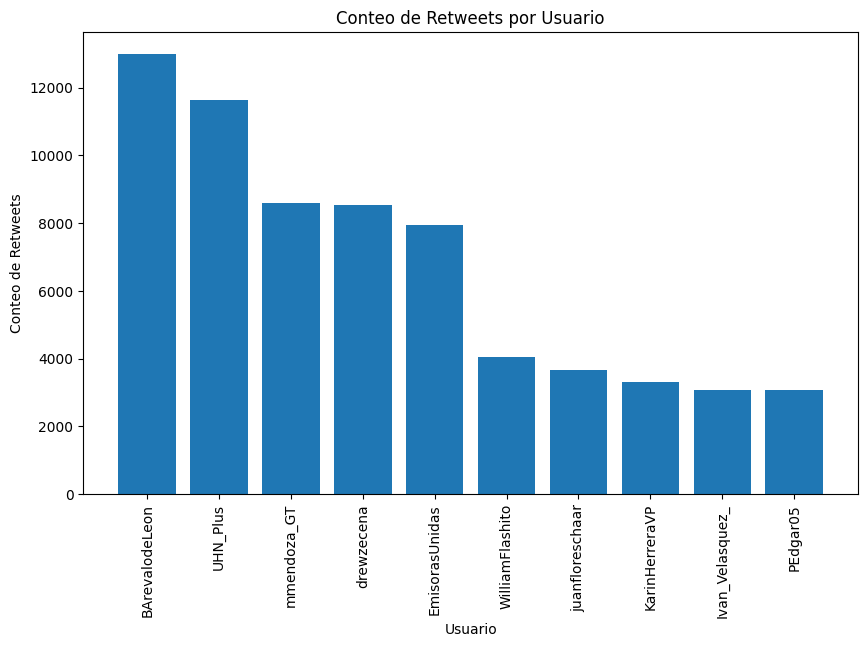

In [155]:
tweets_mas_rt_s = data_sandra.groupby('username')['retweetCount'].sum()
tr_count_df_s = tweets_mas_rt_s.reset_index()
tr_count_df_s = tr_count_df_s.rename(columns={'retweetCount': 'count'})
tr_count_df_s = tr_count_df_s.sort_values(by='count', ascending=False)
tr_count_df_s = tr_count_df_s.head(10)

plt.figure(figsize=(10, 6))  # Tamaño del gráfico
plt.bar(tr_count_df_s['username'], tr_count_df_s['count'])
plt.xlabel('Usuario')
plt.ylabel('Conteo de Retweets')
plt.title('Conteo de Retweets por Usuario')
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x para una mejor visualización
plt.show()


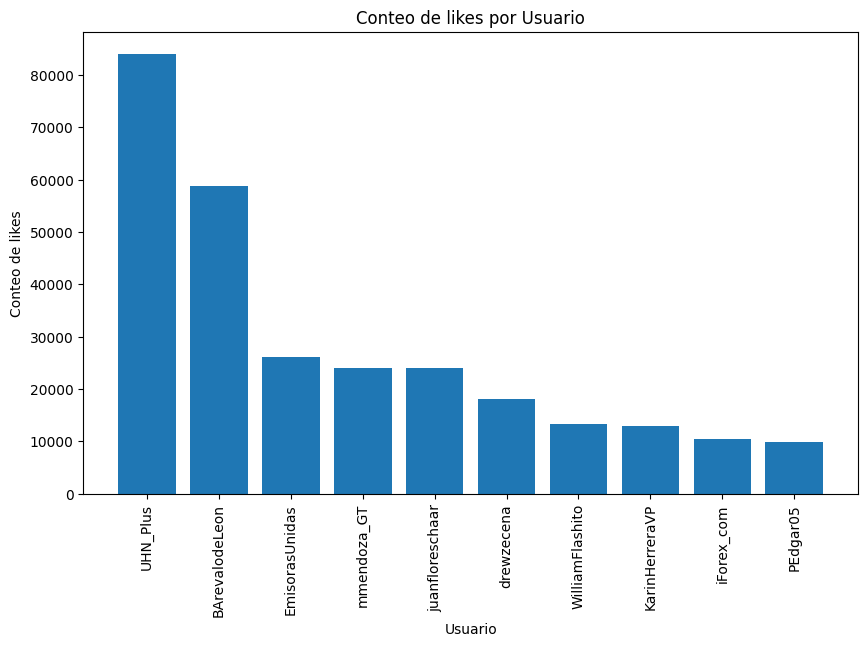

In [114]:
tweets_mas_likes = data_sandra.groupby('username')['likeCount'].sum()
tr_count_df_likes = tweets_mas_likes.reset_index()
tr_count_df_likes = tr_count_df_likes.rename(columns={'likeCount': 'count'})
tr_count_df_likes = tr_count_df_likes.sort_values(by='count', ascending=False)
tr_count_df_likes = tr_count_df_likes.head(10)

plt.figure(figsize=(10, 6))  # Tamaño del gráfico
plt.bar(tr_count_df_likes['username'], tr_count_df_likes['count'])
plt.xlabel('Usuario')
plt.ylabel('Conteo de likes')
plt.title('Conteo de likes por Usuario')
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x para una mejor visualización
plt.show()

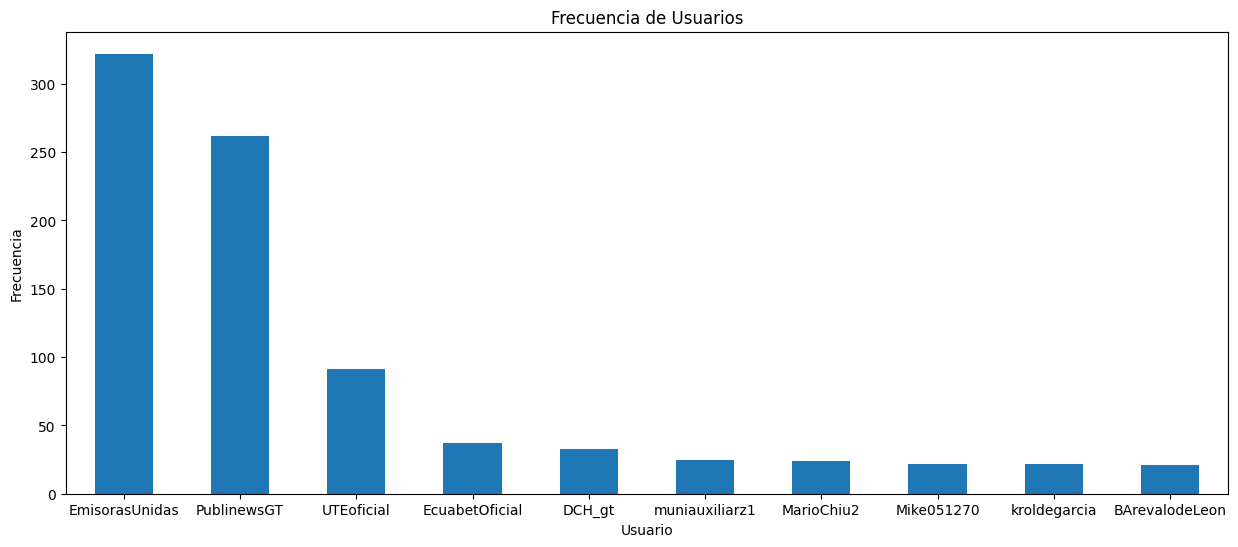

In [126]:
frecuencia_usuarios_s = data_sandra['username'].value_counts()

usuarios_ordenados_s = frecuencia_usuarios_s.sort_values(ascending=False)

# Tomar los 10 usuarios más frecuentes
top_10_usuarios_s = usuarios_ordenados_s.head(10)

# Crear un gráfico de barras
plt.figure(figsize=(15, 6))  # Tamaño del gráfico
top_10_usuarios_s.plot(kind='bar')
plt.xlabel('Usuario')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Usuarios')
plt.xticks(rotation=0)  # Rotar las etiquetas del eje x para una mejor visualización
plt.show()

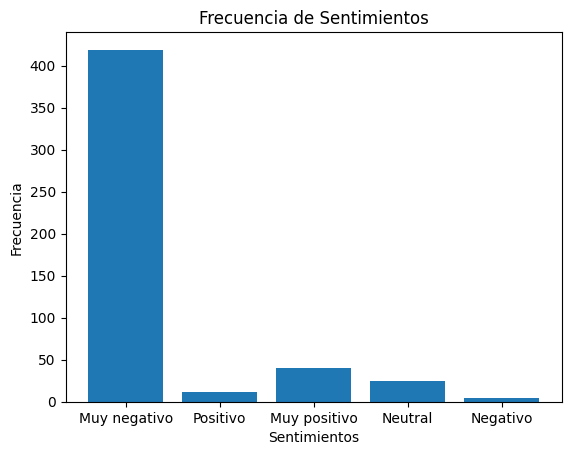

In [121]:
tweets = data_sandra['rawContent_clean'].sample(500)
verificar_sentimiento_tweet(tweets)


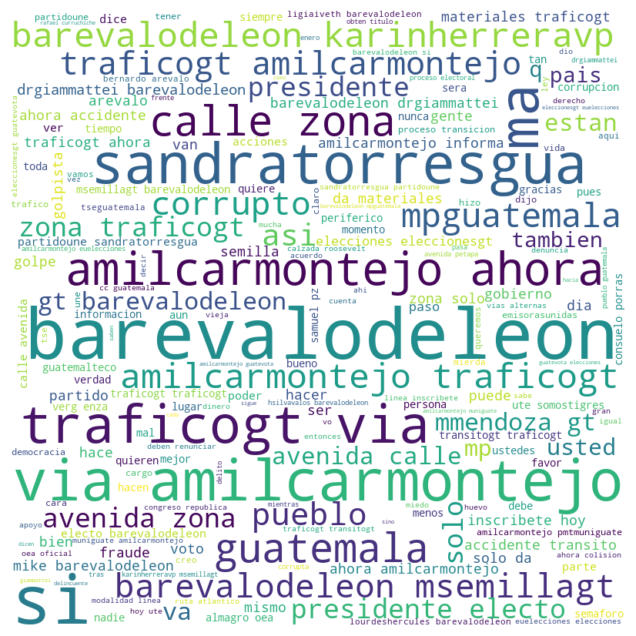

In [156]:
generate_wordcloud(' '.join(data_sandra['rawContent_clean']))

In [153]:
retweet_count = data_sandra['retweetCount'].values
max = np.max(retweet_count)
min = np.min(retweet_count)
retweet_count = (retweet_count - min) / (max - min)
max = 1
min = 0
n = len(retweet_count)
C = interaction_centralization(max, retweet_count, n)
print("La métrica de centralización, basada en interacciones para los tweets de Sandra Torres es:", C)

La métrica de centralización, basada en interacciones para los tweets de Sandra Torres es: 0.9998008559088566


## 5. Descubrimiento

**¿La opinión pública de cada uno de los candidatos es en su mayoría positiva o negativa?**

Al hacer un análisis de sentimiento de los tweets relacionados a cada candidato, se puede observar que en general son de carácter muy negativo, sin embargo, esto se puede deber a que hablan de política y el modelo los clasifica de esta forma. Por otra parte, al comparar la cantidad de Tweets muy positivos, se puede observar que Bernardo tiene una mayor cantidad en comparación con Sandra Torres, por lo que es posible que la opinión sea más positiva para Bernardo.

**¿Encontró algún influencer?**  

Curiosamente, tanto en los tweets de Sandra como en los de Bernardo, Bernardo es un influencer, quedando siempre en el top 2 de cantidad de retweets y likes. También aparece Emisoras Unidas como un influencer en los tweets de ambos candidatos y otros nombres como Karin Herrera e Iván Velásquez.

**¿Cómo describiría la estructura de la red de cada uno de los candidatos centralizada o distribuida?**  

Realizamos nuestra propia métrica de centralización, debido a que no tenemos datos relacionados a la red en sí. Por lo tanto, usamos una métrica basada en cantidad de retweets. Se puede observar que en ambos datasets, la métrica de centralización es bastante alta, de 0.99. Por lo tanto, la mayor cantidad de interacciones se centran en unas pocas publicaciones, lo que indica que la red es centralizada.

**¿Fue durante su campaña la red social un aspecto importante para influir en la decisión de los guatemaltecos?**  
Dados los resultados del análisis exploratorio podemos decir que la red social fue un aspecto importante para influir en la decisión de los guatemaltecos, ya que en ambos casos, la estructura de la red es centralizada, lo que indica que hubo una gran cantidad de interacciones en pocas publicaciones. Además, se puede observar que Bernardo es un influencer en ambos datasets, lo que indica que sus publicaciones fueron muy compartidas y retweeteadas.

## 6. Conclusiones

Dados los resultados de las elecciones y el análisis de redes en twitter podemos concluir que el equipo de Bernardo Arévalo tuvo una mejor estrategia en redes sociales, ya que se puede observar que la red de Bernardo esta centralizada siendo el el punto central. Además, se puede observar que Bernardo es un influencer en ambos datasets, lo que indica que sus publicaciones fueron muy compartidas y retweeteadas. Interactuando tanto con sus simpatizantes como con sus detractores. Por otra parte, Sandra Torres no es un influencer en ninguno de los datasets, lo que indica que sus publicaciones no fueron compartidas ni retweeteadas. Esto deja en claro cual fue la estrategia por parte del partido semilla al concentrarse en los medios digitales y redes sociales para llegar a la población guatemalteca.

